In [1]:
import pandas as pd

sampler_shots = 100

df = pd.read_csv('processed_data.csv')

X = df.drop(columns=['is_fraud']).to_numpy()
y = df['is_fraud'].to_numpy()

n_features = X.shape[1]
n_samples = X.shape[0]

train_percent = 0.999
use_pca = True
n_pca_components = 3
use_lof = False
use_randomized_subsampling = True
desired_num_samples = 1_000

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_percent, random_state=42)

# Anomalies should be labeled -1, normal points should be labeled 1
# Now they are 0 (normal) and 1 (anomaly)
y_train[y_train == 1] = -1
y_test[y_test == 1] = -1
y_train[y_train == 0] = 1
y_test[y_test == 0] = 1


In [2]:
# Use StandardScaler to scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

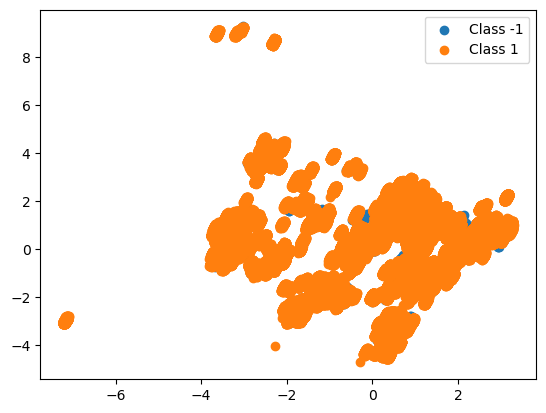

In [3]:
# Plot the data using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
pca_vis = PCA(n_components=2)
X_pca_vis = pca_vis.fit_transform(X_train_scaled)
for c in np.unique(y_train):
    plt.scatter(X_pca_vis[y_train==c, 0], X_pca_vis[y_train==c, 1], label=f'Class {c}')
plt.legend()
plt.show()

In [4]:
# Use PCA
from sklearn.decomposition import PCA
if use_pca:
    pca = PCA(n_components=n_pca_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")
else:
    X_train_pca = X_train_scaled
    X_test_pca = X_test_scaled


Explained variance ratio: 1.00


In [5]:
from sklearn.neighbors import LocalOutlierFactor
if use_lof:
    # Use Local Outlier Factor to find density scores

    lof = LocalOutlierFactor(n_neighbors=20)
    density_scores = -lof.fit_predict(X_train_pca)

    # Keep samples with low density (potentially near anomalies)
    keep_idx = density_scores.argsort()[:desired_num_samples]
    X_train_resized = X_train_pca[keep_idx]
    y_train_resized = y_train[keep_idx]
elif use_randomized_subsampling:
    # Randomly sample a subset of the training data
    if desired_num_samples > X_train_pca.shape[0]:
        raise ValueError("desired_num_samples cannot be greater than the number of training samples.")
    
    indices = np.random.choice(X_train_pca.shape[0], size=desired_num_samples, replace=False)
    X_train_resized = X_train_pca[indices]
    y_train_resized = y_train[indices]
else:
    X_train_resized = X_train_pca
    y_train_resized = y_train

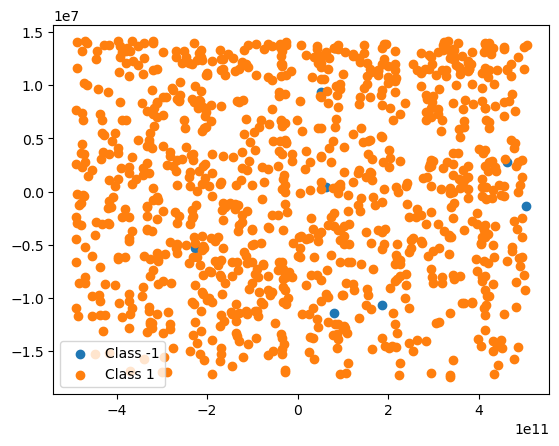

In [6]:
# Plot the data using feature 1 and feature 2
import matplotlib.pyplot as plt
import numpy as np
for c in np.unique(y_train_resized):
    plt.scatter(X_train_resized[y_train_resized==c, 0], X_train_resized[y_train_resized==c, 1], label=f'Class {c}')
plt.legend()
plt.show()


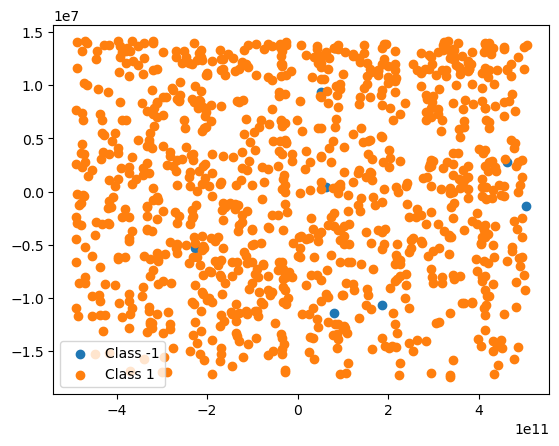

In [7]:
# Plot the data using PCA
from sklearn.decomposition import PCA
pca_vis = PCA(n_components=2)
X_pca_vis = pca_vis.fit_transform(X_train_resized)
for c in np.unique(y_train_resized):
    plt.scatter(X_train_resized[y_train_resized==c, 0], X_train_resized[y_train_resized==c, 1], label=f'Class {c}')
plt.legend()
plt.show()


In [8]:
# Make benchmark with OneClassSVM
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, accuracy_score
ocsvm = OneClassSVM()
ocsvm.fit(X_train_resized, y_train_resized)
# Print training accuracy
y_pred_train = ocsvm.predict(X_train_resized)
print("Training:")
print(classification_report(y_train_resized, y_pred_train))
# Print test accuracy
y_pred = ocsvm.predict(X_test_pca)
print("Test:")
print(classification_report(y_test, y_pred))


Training:
              precision    recall  f1-score   support

          -1       0.01      0.62      0.02         8
           1       0.99      0.50      0.66       992

    accuracy                           0.50      1000
   macro avg       0.50      0.56      0.34      1000
weighted avg       0.99      0.50      0.66      1000

Test:
              precision    recall  f1-score   support

          -1       0.01      0.44      0.02         9
           1       0.99      0.53      0.69       872

    accuracy                           0.52       881
   macro avg       0.50      0.48      0.35       881
weighted avg       0.98      0.52      0.68       881



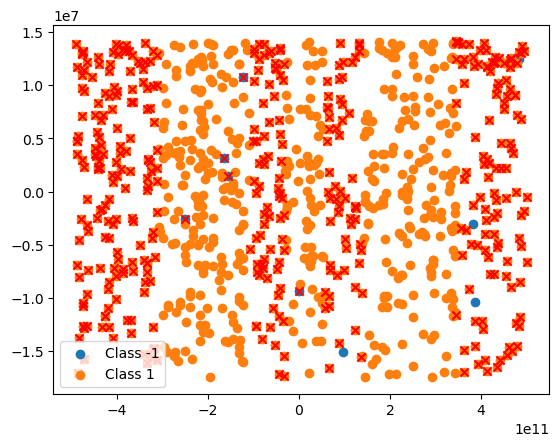

In [9]:
# Visualize the data putting red crosses on data not correctly classified (for test)
for c in np.unique(y_test):
    plt.scatter(X_test_pca[y_test==c, 0], X_test_pca[y_test==c, 1], label=f'Class {c}')
for i in range(len(y_test)):
    # red crosses for misclassified points
    if y_test[i] != y_pred[i]:
        plt.scatter(X_test_pca[i, 0], X_test_pca[i, 1], color='red', marker='x')
plt.legend()
plt.show()


In [10]:
n_qubits = X_train_resized.shape[1]
print(f"Number of qubits: {n_qubits}")

Number of qubits: 3


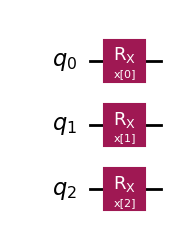

In [11]:
from qiskit.circuit.library import zz_feature_map
# Create the encoding circuit
# Circuit 1
#enc_qc = zz_feature_map(n_qubits,parameter_prefix='x')
# Circuit 2 (angle encoding in Rx)
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
params = ParameterVector('x', n_qubits)
enc_qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    enc_qc.rx(params[i], i)

enc_qc.draw('mpl', fold=-1)

In [12]:
from OCQSVM import OneClassQSVM
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_ibm_runtime import Sampler
from qiskit_aer import AerSimulator
# Create the OneClassQSVM instance
compute_uncompute = ComputeUncompute(sampler=Sampler(mode=AerSimulator(), options={'default_shots': sampler_shots}))
kernel = FidelityQuantumKernel(feature_map=enc_qc,
                               fidelity=compute_uncompute)
ocqsvm = OneClassQSVM(quantum_kernel=kernel, verbose=True)
# Fit the model
ocqsvm.fit(X_train_resized, y_train_resized)

[LibSVM]

,quantum_kernel,<qiskit_machi...0023C1C9667B0>
,cache_size,200
,coef0,0.0
,degree,3
,gamma,'scale'
,max_iter,-1
,nu,0.5
,shrinking,True
,tol,0.001
,verbose,True


In [ ]:
# Print training accuracy
y_pred_train = ocqsvm.predict(X_train_resized)
print("Training:")
print(classification_report(y_train_resized, y_pred_train))
# Print test accuracy
y_pred = ocqsvm.predict(X_test_pca)
print("Test:")
print(classification_report(y_test, y_pred))

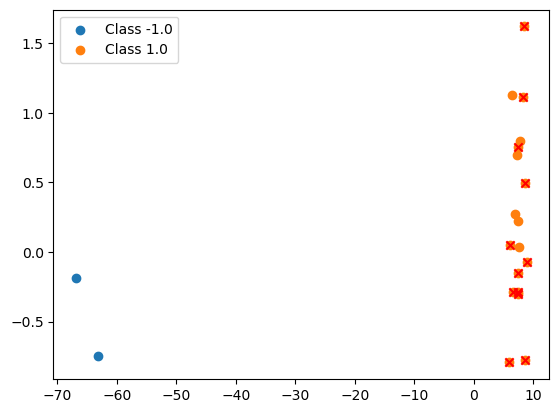

In [ ]:
# Visualize the data
import matplotlib.pyplot as plt
for c in np.unique(y_test):
    plt.scatter(X_test_pca[y_test==c, 0], X_test_pca[y_test==c, 1], label=f'Class {c}')
for i in range(len(y_test)):
    # red crosses for misclassified points
    if y_test[i] != y_pred[i]:
        plt.scatter(X_test_pca[i, 0], X_test_pca[i, 1], color='red', marker='x')
plt.legend()
plt.show()